In [1]:
# Folk from Feature Engineering V_1.0

import numpy as np 
import pandas as pd 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv


In [2]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [3]:
train,test,train_labels,specs,sample_submission=read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [4]:
train_labels.loc[(train_labels["game_session"]=="c996482b11d149dd") & (train_labels["installation_id"]=="ffc90c32")]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.0,3


In [5]:
train_example=train.loc[train["event_id"]=="45d01abe"]
print(train_example.head(1))

      event_id      game_session                 timestamp  \
4138  45d01abe  a9ef3ecb3d1acc6a  2019-08-06T20:50:12.119Z   

                                             event_data installation_id  \
4138  {"description":"Nice work. All the caterpillar...        0006a69f   

      event_count  event_code  game_time                       title  \
4138           15        3021      13050  Bird Measurer (Assessment)   

            type        world  
4138  Assessment  TREETOPCITY  


In [6]:
#use one example to get an idea of the relationship between files#
##
train_example=train.loc[(train["installation_id"]=="99e0c131") &( train["game_session"]=='0d74efd482cfd843')]


In [7]:
import json

a=['f56e0afc', 'ec138c1c', '1375ccb7', '51102b85', 'a16a373e', 'bdf49a58',
 '4a4c3d21' ,'17113b36', '45d01abe', '7525289a' ,'f6947f54' ,'8fee50e2',
 'd38c2fd7' ,'070a5291', '3393b68b']

for A in a:
    print(A)
    print(specs.loc[specs["event_id"]==A])


f56e0afc
     event_id                                               info  \
176  f56e0afc  The start game event is triggered at the very ...   

                                                  args  
176  [{"name":"game_time","type":"int","info":"mill...  
ec138c1c
     event_id                                               info  \
252  ec138c1c  The start round event is triggered at the star...   

                                                  args  
252  [{"name":"game_time","type":"int","info":"mill...  
1375ccb7
    event_id                                               info  \
30  1375ccb7  The system-initiated instruction event occurs ...   

                                                 args  
30  [{"name":"game_time","type":"int","info":"mill...  
51102b85
     event_id                                               info  \
321  51102b85  This event occurs when the player picks up a h...   

                                                  args  
321  [{"name":"game_t

In [8]:
train_example.loc[train_example["event_id"]=="ea296733"]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
6868519,ea296733,0d74efd482cfd843,2019-10-08T16:41:50.045Z,"{""description"":""Uh oh. Looks like you need to ...",99e0c131,14,3020,14589,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
6868528,ea296733,0d74efd482cfd843,2019-10-08T16:42:00.302Z,"{""description"":""Uh oh. Looks like you need to ...",99e0c131,23,3020,24838,Chest Sorter (Assessment),Assessment,CRYSTALCAVES


In [9]:
#ea296733 incorrect attemp event Id with event code 3020#
#45d01abe correct attemp evne tid with even code 3021 #

specs_example=specs.loc[specs["event_id"]=="0db6d71d"]
print(specs_example)

    event_id                                               info  \
63  0db6d71d  This event occurs when the player places a che...   

                                                 args  
63  [{"name":"game_time","type":"int","info":"mill...  


In [10]:
train_labels_example=train_labels.loc[train_labels["installation_id"]=='99e0c131']

In [11]:
train_labels_example.head(5)
#train_labels and train is a "one-to-many" relationship. In train_labels, one entry correspond to the result of a certain game, indicated in game_sesison,
#by the person, indicated in installation_id. In train, one entry correspond to events, can be start, etc. 

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
10953,0d74efd482cfd843,99e0c131,Chest Sorter (Assessment),0,2,0.0,0


In [12]:
def encode_title(train, test, train_labels):
    # encode title
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
     
    
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    
    
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    
    
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels

In [13]:
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels=encode_title(train,test,train_labels)
#encode the words#

In [14]:
print(len(list_of_user_activities))
print(len(list_of_event_code))


44
42


### Below is the exploration of one single installation


In [15]:
user_sample_id=train.sample(1,random_state=42)["installation_id"]
print(str(user_sample_id))
user_sample=train.loc[train["installation_id"]=="78564920"]
user_sample

5451677    78564920
Name: installation_id, dtype: object


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
5447321,27253bdc,b72a10708d44588a,2019-09-10 00:48:49.561000+00:00,"{""event_code"": 2000, ""event_count"": 1}",78564920,1,2000,0,35,Clip,2
5447322,27253bdc,488d3352fc3e84ca,2019-09-10 00:49:15.141000+00:00,"{""event_code"": 2000, ""event_count"": 1}",78564920,1,2000,0,29,Clip,0
5447323,27253bdc,d93f26d60514ebff,2019-09-10 00:50:05.585000+00:00,"{""event_code"": 2000, ""event_count"": 1}",78564920,1,2000,0,33,Clip,0
5447324,27253bdc,a42ce77fc77ab2ea,2019-09-10 00:51:05.697000+00:00,"{""event_code"": 2000, ""event_count"": 1}",78564920,1,2000,0,34,Clip,1
5447325,27253bdc,cd954a4361415964,2019-09-10 00:51:55.882000+00:00,"{""event_code"": 2000, ""event_count"": 1}",78564920,1,2000,0,2,Clip,1
...,...,...,...,...,...,...,...,...,...,...,...
5452016,1bb5fbdb,7449d5268e2f6ade,2019-10-10 23:24:59.986000+00:00,"{""description"":""Drag the shovel to the molds t...",78564920,266,3110,478495,6,Activity,0
5452017,b2dba42b,7449d5268e2f6ade,2019-10-10 23:25:11.976000+00:00,"{""description"":""Drag the shovel to the molds t...",78564920,267,3010,490480,6,Activity,0
5452018,1bb5fbdb,7449d5268e2f6ade,2019-10-10 23:25:14.051000+00:00,"{""description"":""Drag the shovel to the molds t...",78564920,268,3110,492563,6,Activity,0
5452019,b2dba42b,7449d5268e2f6ade,2019-10-10 23:25:26.043000+00:00,"{""description"":""Drag the shovel to the molds t...",78564920,269,3010,504547,6,Activity,0


In [16]:
print(len(user_sample.game_session.unique()),user_sample.count())

122 event_id           4700
game_session       4700
timestamp          4700
event_data         4700
installation_id    4700
event_count        4700
event_code         4700
game_time          4700
title              4700
type               4700
world              4700
dtype: int64


In [17]:
user_sample.groupby("game_session").count()
#each row correspond to number event happens in single game_session#


,event_id,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
game_session,,,,,,,,,,
0280ace6b6b01057,32,32,32,32,32,32,32,32,32,32
04948b3bf1b950dd,1,1,1,1,1,1,1,1,1,1
04a85f3968a85ea8,103,103,103,103,103,103,103,103,103,103
05207ade18f1b9c4,51,51,51,51,51,51,51,51,51,51
0642c2b54f98e54b,28,28,28,28,28,28,28,28,28,28
...,...,...,...,...,...,...,...,...,...,...
fadcc8da93639763,1,1,1,1,1,1,1,1,1,1
fbc0908ce91ed161,1,1,1,1,1,1,1,1,1,1
fcd6d8a4660817a7,37,37,37,37,37,37,37,37,37,37


### Out of 122 game sessions, only 22 of them have records in train_label, which means only 22 of them is a game that really have a accuracy result

In [18]:
list=user_sample.game_session
user_sample_train_labels=train_labels.loc[train_labels["game_session"].isin(list)]
print(user_sample_train_labels.count())

valid_game=user_sample_train_labels
valid_game


game_session       22
installation_id    22
title              22
num_correct        22
num_incorrect      22
accuracy           22
accuracy_group     22
dtype: int64


,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
8726,0280ace6b6b01057,78564920,12,1,0,1.000000,3
8727,05207ade18f1b9c4,78564920,12,1,1,0.500000,2
8728,0642c2b54f98e54b,78564920,12,1,0,1.000000,3
8729,0998f80d94ce6723,78564920,10,1,2,0.333333,1
8730,09c9356225483890,78564920,41,1,0,1.000000,3
8731,0ea000307ff09e8e,78564920,14,1,1,0.500000,2
8732,12fe440decf8c0ab,78564920,10,1,0,1.000000,3
8733,1f017111494b2654,78564920,14,0,2,0.000000,0
8734,474e91e7f57234f4,78564920,41,1,0,1.000000,3
8735,571d2eab61b3d423,78564920,38,0,5,0.000000,0


### for this selected installation id, which is 78564920, there are 4700 events recorded in train.csv
### and out of this 4700, only 122 game session is happended. 
### and out of this 122 game session, only 22 is valid game, having an accuracy score

### !!!!!!!!!!!!!!! question: Whether to filter out these non-accuracy-score game


### for these 22 valid game, how much time is spent


In [19]:
valid_game_id=valid_game.game_session
user_sample_valid=user_sample.loc[user_sample["game_session"].isin(valid_game_id)]
user_sample_valid.groupby("game_session").count()

,event_id,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
game_session,,,,,,,,,,
0280ace6b6b01057,32,32,32,32,32,32,32,32,32,32
05207ade18f1b9c4,51,51,51,51,51,51,51,51,51,51
0642c2b54f98e54b,28,28,28,28,28,28,28,28,28,28
0998f80d94ce6723,59,59,59,59,59,59,59,59,59,59
09c9356225483890,40,40,40,40,40,40,40,40,40,40
0ea000307ff09e8e,54,54,54,54,54,54,54,54,54,54
12fe440decf8c0ab,28,28,28,28,28,28,28,28,28,28
1f017111494b2654,32,32,32,32,32,32,32,32,32,32
474e91e7f57234f4,37,37,37,37,37,37,37,37,37,37


In [20]:
import json
def add_event_features(game_id):

    result=[]
    sample_game=user_sample.loc[user_sample["game_session"]==game_id].event_data
    for i in sample_game:
        event_code=int(i[-5:-1])
        if((event_code==4100) or (event_code==4110) ):
            result.append(i)
    count_before_1=0
    time_before_1=0
    total_duration_1=0
    count_before_2=0
    time_before_2=0
    total_duration_2=0
    count_beyond=0
    time_beyond=0
    total_duration_beyond=0
    count=len(result)
    if(count>=1):
        count_before_1=json.loads(result[0])["event_count"]
        time_before_1=json.loads(result[0])["game_time"]
    if(count>=2):
        count_before_2=json.loads(result[1])["event_count"]
        time_before_2=json.loads(result[1])["game_time"]
    if(count>=3):
        count_beyond=json.loads(result[2])["event_count"]
        time_beyond=json.loads(result[2])["game_time"]
    return count_before_1,time_before_1,count_before_2,time_before_2,count_beyond,time_beyond


# print(add_event_features().count)

In [21]:
id_list=valid_game_id.tolist()
features=pd.DataFrame(valid_game_id)
features["game_start"]=np.zeros(len(valid_game_id))
pd.to_datetime(features["game_start"])
features["game_end"]=np.zeros(len(valid_game_id))
pd.to_datetime(features["game_end"])
features["game_duration"]=np.zeros(len(valid_game_id))
pd.to_datetime(features["game_duration"])
features["num_correct"]=np.zeros(len(valid_game_id))
features["num_incorrect"]=np.zeros(len(valid_game_id))
features["accuracy"]=np.zeros(len(valid_game_id))
features["accuracy_group"]=np.zeros(len(valid_game_id))
features["title"]=np.zeros(len(valid_game_id))
features["installation_id"]=np.full(len(valid_game_id),"78564920")
features["world"]=np.zeros(len(valid_game_id))
features["before_1_attemp_event_count"]=np.zeros(len(valid_game_id))
features["before_1_attemp_game_time"]=np.zeros(len(valid_game_id))
features["between_1_2_attemp_event_count"]=np.zeros(len(valid_game_id))
features["between_1_2_attemp_game_time"]=np.zeros(len(valid_game_id))
features["beyond_2_attemp_event_count"]=np.zeros(len(valid_game_id))
features["beyond_2_attemp_game_time"]=np.zeros(len(valid_game_id))



count=0
for i in id_list:

    label=user_sample_train_labels.loc[user_sample_train_labels["game_session"]==i]
    features["game_start"].iloc[count]=user_sample_valid.loc[user_sample_valid["game_session"]==i].timestamp.iloc[0]
    features["game_end"].iloc[count]=user_sample_valid.loc[user_sample_valid["game_session"]==i].timestamp.iloc[-1]
    features['game_duration'].iloc[count]=(user_sample_valid.loc[user_sample_valid["game_session"]==i].timestamp.iloc[-1]-user_sample_valid.loc[user_sample_valid["game_session"]==i].timestamp.iloc[0]).seconds
    features["num_correct"].iloc[count]=label.iloc[0].num_correct
    features["num_incorrect"].iloc[count]=label.iloc[0].num_incorrect
    features["title"].iloc[count]=label.iloc[0].title
    features["accuracy"].iloc[count]=label.iloc[0].accuracy
    features["accuracy_group"].iloc[count]=label.iloc[0].accuracy_group
    features["world"].iloc[count]=user_sample_valid.loc[user_sample_valid["game_session"]==i].world.iloc[0]
    count_1,time_1,count_2,time_2,count_3,time_3=add_event_features(i)
    print(i,count_1,time_1,duration_1,count_2,time_2,duration_2,count_3,time_3,duration_3)
    features["before_1_attemp_event_count"].iloc[count]=count_1
    features["before_1_attemp_game_time"].iloc[count]=time_1
    features["between_1_2_attemp_event_count"].iloc[count]=count_2
    features["between_1_2_attemp_game_time"].iloc[count]=time_2
    features["beyond_2_attemp_event_count"].iloc[count]=count_3
    features["beyond_2_attemp_game_time"].iloc[count]=time_3
    count+=1
    

features


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


NameError: name 'duration_1' is not defined

###control of time unit

# can title be unique identifier of the game ? 
# or world also need to play a part?


In [22]:

sample_game=train.loc[train["game_session"]=="0280ace6b6b01057"]

for i in sample_game.event_data:
    print(i)

{"version":"1.0","event_count":1,"game_time":0,"event_code":2000}
{"crystals":[{"id":"gem07","weight":6},{"id":"gem05","weight":4},{"id":"gem01","weight":1},{"id":"gem03","weight":3},{"id":"gem02","weight":1},{"id":"gem08","weight":6},{"id":"gem04","weight":3},{"id":"gem06","weight":4}],"event_count":2,"game_time":53,"event_code":2020}
{"description":"We've got to balance this scale! Fill the trays with gems so both sides weigh the same! Use your finger to drag the gems to the trays!","identifier":"Dot_BalanceScale,Dot_FillTrays,Dot_UseFingerDragGems","media_type":"audio","total_duration":6970,"event_count":3,"game_time":53,"event_code":3010}
{"crystal_id":"gem07","weight":6,"coordinates":{"x":194,"y":609,"stage_width":1015,"stage_height":762},"source":"resources","crystals":[{"id":"gem05","weight":4},{"id":"gem01","weight":1},{"id":"gem03","weight":3},{"id":"gem02","weight":1},{"id":"gem08","weight":6},{"id":"gem04","weight":3},{"id":"gem06","weight":4}],"event_count":4,"game_time":34

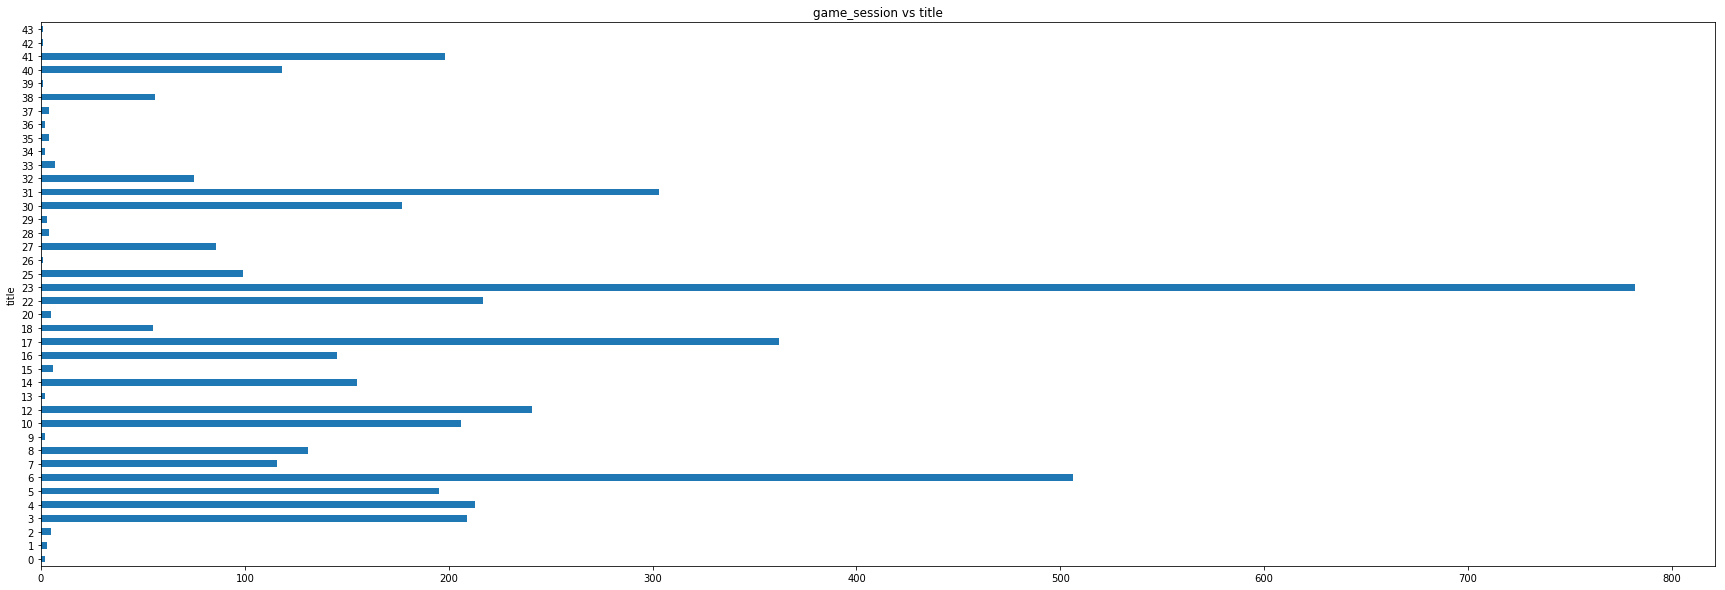

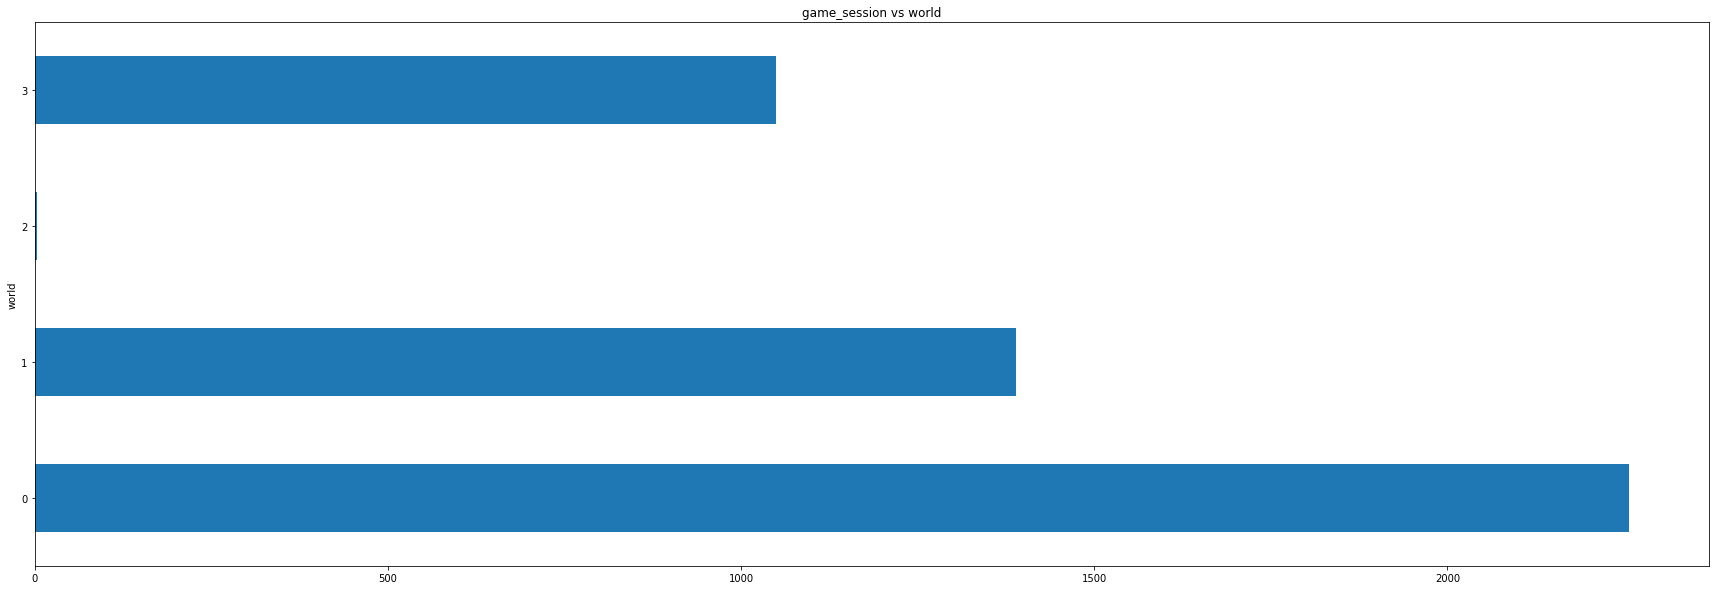

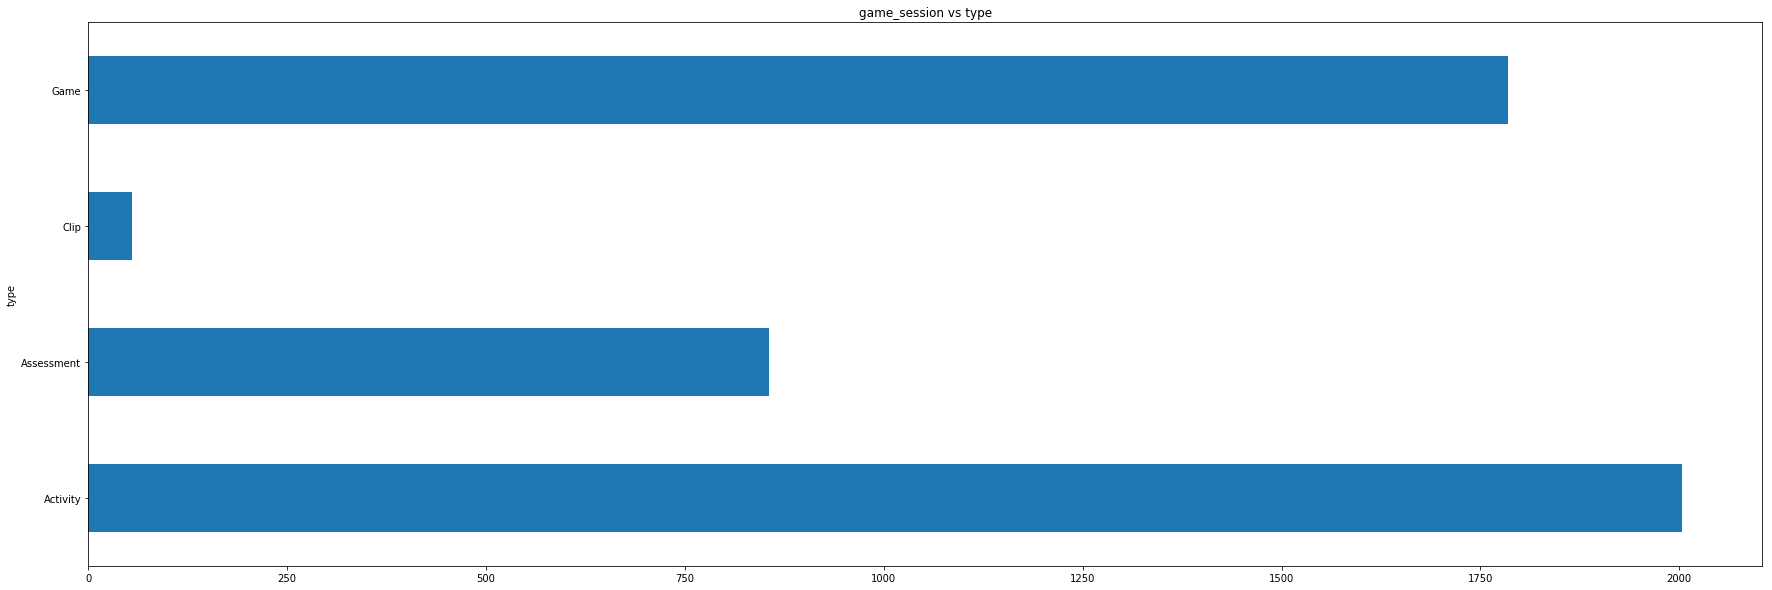

In [23]:
import matplotlib.pylab as plt
user_sample.groupby("title")["game_session"].count().plot(kind='barh', figsize=(30,10), title='game_session vs title')
plt.show() 
#for single installation_id which is 78564920#
#the game_session histo for every title#
##what does game_session mean ? #

user_sample.groupby("world")["game_session"].count().plot(kind='barh', figsize=(30,10), title='game_session vs world')
plt.show() 

user_sample.groupby("type")["game_session"].count().plot(kind='barh', figsize=(30,10), title='game_session vs type')
plt.show() 